In [73]:
import math
import numpy as np
from math import sqrt
import pandas as pd
import cv2

def frame_con(point,rotmat,org):
    point=np.array(point)
    point=point.reshape(3,1)
    point=point-org 
    point=np.matmul(rotmat.T,point)
    return point

def RMSE(y_true, y_pred,time_true,time_pred):
    from scipy.signal import savgol_filter
    '''
    y_true,y_pred : list/listlike containing the true and predicted values respectively
    time_true,time_pred : list/listlike containing the time values
    returns : RMSE value
    '''
    yp2,tp2,yt2,tt2=[],[],[],[]

    for i in range(len(y_pred)):
        if not math.isnan(y_pred[i]):
            yp2.append(y_pred[i])
            tp2.append(time_pred[i])
    
    for i in range(len(y_true)):
        if not math.isnan(y_true[i]):
            yt2.append(y_true[i])
            tt2.append(time_true[i])
   
    y_pred=yp2
    time_pred=tp2
    y_true=yt2
    time_true=tt2

    try:
        y_pred=savgol_filter(y_pred,  int(len(y_pred)/20),3)
    except:
        y_pred=savgol_filter(y_pred,  int(len(y_pred)/20)+1,3)

    y_true=savgol_filter(y_true,  5,3)
    y_true_dic={}
    y_true_shortened=[]
    y_true_dic = {time_true[i]: y_true[i] for i in range(len(y_true))}


    y_true=list(y_true)
    y_pred=list(y_pred)
    time_true=list(time_true)
    time_pred=list(time_pred)
    #removing excess values and making pred and true the same size
    while(time_pred[0]<time_true[0]):
        time_pred.pop(0)
        y_pred.pop(0)
    while(time_pred[-1]>time_true[-1]):
        time_pred.pop(-1)
        y_pred.pop(-1)
    while(time_pred[0]>time_true[0]):
        time_true.pop(0)
        y_true.pop(0)
    while(time_pred[-1]>time_true[-1]):
        time_true.pop(-1)
        y_true.pop(-1)

    for i in range(1,len(time_pred)):
        mean_calc=[]
        n=0
        for key,value in y_true_dic.items():
            if time_pred[i]>=key>=time_pred[i-1]:
                mean_calc.append(value)
                n+=1
        if n!=0:
            y_true_shortened.append(sum(mean_calc)/n)      
    while (len(y_true_shortened)<len(y_pred)):
        y_pred.pop(0)
    while (len(y_true_shortened)>len(y_pred)):
        y_true_shortened.pop(0)

    return np.sqrt(np.mean((np.array(y_true_shortened) - np.array(y_pred)) ** 2)) , abs(np.max((np.array(y_true_shortened) - np.array(y_pred))))

def angle3point(a,b,c):
    import mpmath
    '''
    a,b,c : 1D lists/like representing the points
    return : angle in degrees
    '''
    a=np.array(a)
    b=np.array(b)
    c=np.array(c)
    
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def angle2vec(a,b):
    '''
    a,b : 1D lists/like representing the vectors
    return : angle in degrees
    '''
    a=np.array(a)
    b=np.array(b)
    
    cosine_angle = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    angle = np.arccos(cosine_angle)

    return np.degrees(angle)

def project_onto_plane(point, plane_points):
    '''
    Projects a point onto a plane.
    point: a list containing a 3D point
    plane_points: a list containing 3 3D points on the plane
    returns : projection of the point onto the plane
    '''
    # Convert the points to numpy arrays
    point = np.array(point)
    plane_points = np.array(plane_points)
    # print(point,'\n',plane_points)

    # Calculate the plane's normal vector
    v1 = plane_points[1] - plane_points[0]
    v2 = plane_points[2] - plane_points[0]
    # print(v1,'\n',v2)

    #calculate unit normal
    normal = np.cross(v1, v2)
    unitnorm=normal/np.linalg.norm(normal)

    #point projection onto normal
    pp=np.dot(unitnorm,point) * unitnorm

    # Calculate the projection of the point onto the plane
    projection = point - pp
    
    return projection.tolist()

def find_orthogonal_points(point1, point2, point3,vec1):
    # Calculate the normal vector of the given plane
    normal_vector = np.cross(point2 - point1, point3 - point1)

def sag_plane(chestplanepoints):

    ''' 
    to calculate the saggital plane
    chestplanepoints: a list containing 3 3D points on the chest
    returns org, cross point, tr point
    '''
    pl=np.array(chestplanepoints)
    org=(pl[1]-pl[2])/2
    norm=pl[1]-org
    v1=pl[0]-org # straight down
    v2=np.cross(norm,v1)
    
    # print(org,'\n',norm,'\n',v,'\n',cross,'\n')
    return[org,org+v2,org+v1]

def midpoint(p1,p2):

    '''
    calculates the midpoint of two points
    p1,p2 : lists/like representing the points
    returns : midpoint
    '''
    mid=[]
    for i in range(len(p1)):
        mid.append((p1[i]+p2[i])/2)
    return mid

def read_df_csv(filename, offset=2):
    """
    this function reads the csv file from motion capture system
    and makes it into a dataframe and returns only useful information

    filename: input path to csv file from motive
    offset:to ignore the first two columns with time and frames generally

    """
    import pandas as pd
    import datetime
    # offset = 2 #first two columns with frame_no and time

    pth = filename
    raw = pd.read_csv(pth)
    cols_list = raw.columns     # first row which contains capture start time
    inx = [i for i, x in enumerate(cols_list) if x == "Capture Start Time"]
    st_time = cols_list[inx[0] + 1]
    st_time = datetime.datetime.strptime(st_time, "%Y-%m-%d %I.%M.%S.%f %p")  # returns datetime object

    mr_inx = pd.read_csv(pth, skiprows=3)
    markers_raw = mr_inx.columns
    marker_offset = offset  # for ignoring time and frame cols
    markers_raw = markers_raw[marker_offset:]
    col_names = []
    for i in range(0, len(markers_raw), 3):
        col_names.append(markers_raw[i].split(":")[1])

    df_headers = ["frame", "seconds"]

    for id, i in enumerate(col_names):
        if not i.islower():
            col_names[id] = i
    
    for i in col_names:
        df_headers.append(i + "_x")
        df_headers.append(i + "_y")
        df_headers.append(i + "_z")
    mo_data = pd.read_csv(pth, skiprows=6)
    # mo_data = mo_data.rename(mo_data.columns, df_headers)
    mo_data.columns = df_headers

    mo_data.drop(['frame'],axis=1,inplace=True)

    return mo_data, st_time

def point_in_quad(point, quadrilateral):
    from matplotlib.path import Path

    vertices = [(p[0], p[1]) for p in quadrilateral]
    path = Path(vertices)
    return path.contains_point(point)

def draw_box(image, point1, point2, color=(0, 255, 0), dis=20):
    """
    Draw a box around two points using OpenCV.

    :param image: Image on which to draw the box
    :param point1: Tuple of x and y coordinates of the first point
    :param point2: Tuple of x and y coordinates of the second point
    :param color: Tuple of BGR values for the color of the box
    :param thickness: Thickness of the lines of the box
    """
    x1, y1 = point1
    x2, y2 = point2

    angle = math.atan2(y2 - y1, x2 - x1)

    # Calculate the new points
    x1 = x1 - (dis + 5) * math.cos(angle)
    y1 = y1 - dis * math.sin(angle)
    x2 = x2 + (dis + 5) * math.cos(angle)
    y2 = y2 + dis * math.sin(angle)

    # Calculate the slope of the line
    slope = (y2 - y1) / (x2 - x1)

    # Calculate the slope of the perpendicular line
    perp_slope = -1 / slope

    # Calculate the angle of the perpendicular line
    angle = math.atan(perp_slope)

    # Calculate the new points
    bp1=(int(x1 + dis * math.cos(angle)),int( y1 + dis * math.sin(angle)))
    bp2=(int(x1 - dis * math.cos(angle)),int( y1 - dis * math.sin(angle)))
    bp3=(int(x2 - dis * math.cos(angle)),int( y2 - dis * math.sin(angle)))
    bp4=(int(x2 + dis * math.cos(angle)),int( y2 + dis * math.sin(angle)))

    try:
        cv2.line(image,bp1,bp2 , color, 2)
        cv2.line(image,bp2,bp3 , color, 2)
        cv2.line(image,bp3,bp4 , color, 2)
        cv2.line(image,bp4,bp1 , color, 2)
    except:
        pass

    return bp1,bp2,bp3,bp4

def find_orthogonal_frame(v1, v2):
    """
    v1:upper arm vector
    v2:lower arm vector
    """
    # Normalize the input vectors
    vy = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Compute the cross product to find the orthogonal vector
    vx = np.cross(v1, v2)
    vx=vx/np.linalg.norm(vx)
    
    # Normalize the orthogonal vector
    vy = vy / np.linalg.norm(vy)

    vz=np.cross(vx,vy)
    vz=vz/np.linalg.norm(vz)

    return np.array([vx,vy,vz])

def find_tr_frame(v1, v2,v3):
    """
    v1 : Right Shoulder
    v2 : Left Shoulder
    v3 : Trunk
    """
    # midpoint
    m=midpoint(v1,v2)
    v1=np.array(v1)
    v2=np.array(v2)
    v3=np.array(v3)
    m=np.array(m)
    
    vy=v3-m
    vy = vy / np.linalg.norm(vy)

    vz=np.cross(vy,v2)
    vz=vz/np.linalg.norm(vz)

    vx=np.cross(vz,vy)
    vx=vx/np.linalg.norm(vx)

    return np.array([vx,vy,vz])

def find_rotation_matrix(frame1_vectors, frame2_vectors):
    # Check if the number of vectors is not equal to 3
    if len(frame1_vectors) != 3 or len(frame2_vectors) != 3:
        raise ValueError("Invalid number of vectors. Expected 3 vectors for each frame.")
    
    # Normalize vectors
    for i in range(3):
        frame1_vectors[i]=frame1_vectors[i]/np.linalg.norm(frame1_vectors[i])
        frame2_vectors[i]=frame2_vectors[i]/np.linalg.norm(frame2_vectors[i])
    
    # Create the rotation matrix by concatenating the unit vectors
    frame1_matrix = np.column_stack(frame1_vectors)
    frame2_matrix = np.column_stack(frame2_vectors)
    
    for matrix in [frame1_matrix,frame2_matrix]:
        if not np.allclose(matrix.T, np.linalg.inv(matrix)) and not np.isclose(np.linalg.det(matrix), 1):
            print(matrix, 'is not valid orthonormal matrix')    
            return
    
    # Calculate the rotation matrix that transforms frame1 to frame2
    rotation_matrix = np.matmul(frame2_matrix, frame1_matrix.T)
    
    return rotation_matrix

def rotation_angles(matrix):
    """
    input
        matrix = 3x3 rotation matrix (numpy array)
        order is yzx, 
    output
        theta1, theta2, theta3 = rotation angles in rotation order
    """
    # matrix=np.array(matrix)
    # matrix=matrix.T
    r11, r12, r13 = matrix[0]
    r21, r22, r23 = matrix[1]
    r31, r32, r33 = matrix[2]

    theta1_neg = False
    theta2_neg = False
    theta3_neg = False

    if r32 < 0:
        theta1_neg = True
    if r12 > 0: 
        theta2_neg = True
    if r13 < 0:
        theta3_neg = True 

    if not theta1_neg:
        if np.rad2deg(np.arctan(r32 / r22)) < 0:
            theta1=(180+np.rad2deg(np.arctan(r32 / r22)))
        else:
            theta1=(np.rad2deg(np.arctan(r32 / r22)))
    else:
        if np.rad2deg(np.arctan(r32 / r22)) < 0:
            theta1=(np.rad2deg(np.arctan(r32 / r22)))
        else:
            theta1=(np.rad2deg(np.arctan(r32 / r22))-180)
    
    if not theta2_neg:
        if np.rad2deg(np.arctan((-r12 * np.cos(np.deg2rad(theta1)) / r22))) < 0:
            theta2=(180+np.rad2deg(np.arctan(-r12 * np.cos(np.deg2rad(theta1)) / r22)))
        else:
            theta2=(np.rad2deg(np.arctan((-r12 * np.cos(np.deg2rad(theta1)) / r22))))
    else:
        if np.rad2deg(np.arctan((-r12 * np.cos(np.deg2rad(theta1)) / r22))) < 0:
            theta2=np.rad2deg(np.arctan(-r12 * np.cos(np.deg2rad(theta1)) / r22))
        else:
            theta2=(np.rad2deg(np.arctan(-r12 * np.cos(np.deg2rad(theta1)) / r22))-180)
    
    if not theta3_neg:
        if np.rad2deg(np.arctan((r13 / r11))) < 0:
            theta3=(180+np.rad2deg(np.arctan((r13 / r11))))
        else:
            theta3=(np.rad2deg(np.arctan((r13 / r11))))
    else:
        if np.rad2deg(np.arctan((r13 / r11))) < 0:
            theta3=np.rad2deg(np.arctan((r13 / r11)))
        else:
            theta3=(np.rad2deg(np.arctan((r13 / r11)))-180)
            
    theta1 = -theta1
    theta2 = -theta2
    theta3 = -theta3

    # # xzy
    # theta1 = np.arctan(r32 / r22)
    # theta2 = np.arctan(-r12 * np.cos(theta1) / r22)
    # theta3 = np.arctan(r13 / r11)

    # theta1 = -theta1 * 180 / np.pi
    # theta2 = -theta2 * 180 / np.pi
    # theta3 = -theta3 * 180 / np.pi

    return [theta1, theta2, theta3]


def errors(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) and maximum error between two lists.

    Parameters:
    - y_true (list): List of true values.
    - y_pred (list): List of predicted values.

    Returns:
    - rmse (float): Root Mean Squared Error.
    - max_error (float): Maximum error.

    Raises:
    - ValueError: If the lengths of y_true and y_pred are different.

    """

    # Check if both lists are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError('Both lists must be of the same length.')

    # Convert the lists to NumPy arrays
    array1 = np.array(y_true)
    array2 = np.array(y_pred)

    mask = ~np.isnan(array1) & ~np.isnan(array2)
    new_array1 = array1[mask]
    new_array2 = array2[mask]

    # slope_mask1 = np.array(high_slope_index(new_array1,window_length=50,slope_threshold=1.5))
    # slope_mask2 = np.array(high_slope_index(new_array2,window_length=50,slope_threshold=1.5))
    # new_array1[slope_mask1] = np.mean(new_array1)
    # new_array2[slope_mask2] = np.mean(new_array2)

    # Calculate the squared difference between the two arrays
    squared_diff = (new_array1 - new_array2) ** 2

    # Calculate the mean of the squared differences
    mean_squared_diff = squared_diff.mean()

    # Calculate the RMSE
    rmse = np.sqrt(mean_squared_diff)

    ## Calculate the absolute differences between the two arrays
    absolute_diff = np.abs(new_array1 - new_array2)

    # Find the maximum error and its index
    max_error = np.max(absolute_diff)
    max_error_index = np.argmax(absolute_diff)

    return rmse, max_error, max_error_index

def split_list_by_indexes(lst, indexes):
    result = []
    start = 0

    for index in indexes:
        result.append(lst[start:index])
        start = index

    # Add the remaining portion of the list
    result.append(lst[start:])

    return result

def high_slope_index(input_list, window_length=200, slope_threshold=0.005):
    output_list = []
    n=window_length
    for i in range(len(input_list)):
        start_idx = max(i - n, 0)
        end_idx = min(i + n + 1, len(input_list))
        surrounding = input_list[start_idx:end_idx]
        slope=np.polyfit(range(len(surrounding)),surrounding,1)[0]
        if abs(slope)>slope_threshold:
            output_list.append(True)
        else:
            output_list.append(False) 
    return output_list

In [74]:
# Importing necessary libraries
# from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
from pptx.util import Pt

current_directory = os.getcwd()
# Read the JSON file containing the Session Directory
with open("C:\\Users\\CMC\\Downloads\\PoseEstimation\\upperbody\\SessionDirectory.json", 'r') as file:
    session_data = json.load(file)
    
# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.drop(columns=['seconds'],inplace=True)
df_mocap.sort_values(by=['epoch_time'])

# applying savgol filter to mocap data 
df_mocap = pd.DataFrame(savgol_filter(df_mocap, 51, 3, axis=0),
                                columns=df_mocap.columns,
                                index=df_mocap.index)

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe_filtered.csv')

df_mpipe.sort_values(by=['epoch_time'])

# drop repeating rows in mpipe
df_mpipe = df_mpipe.drop_duplicates(subset=df_mpipe.columns[0])

# Define the desired column order
column_order = df_mpipe.columns.tolist()

# Reindex the DataFrame with the desired column order
df_mocap = df_mocap.reindex(columns=column_order)

# Creating a presentation to save the graphs in
prs=Presentation()

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

from scipy.interpolate import interp1d

df2=df_mocap.copy()

# Extract the x values from df_mpipe and df2
x = df_mpipe['epoch_time']
x_new = df2['epoch_time']

# Loop through the columns of df2 (excluding epoch_time)
for column in df2.columns[1:]:
    if column in ['TR_x','TR_y','TR_z','LS_x','LS_y','LS_z','RS_x','RS_y','RS_z']:
        k='zero'
    else:
        k='slinear'
    # Extract the y values from df_mpipe for the current column
    y = df_mpipe[column]
    
    # Generate the interpolating function
    interpolating = interp1d(x,y,kind = k,fill_value='extrapolate')
    
    # Interpolate y values onto df2 for the current column
    interpolated_values = interpolating(x_new)
    
    # Add the interpolated values as a new column in df2
    df2['interpolated_' + column] = interpolated_values

df2.drop(df_mocap.columns,axis=1,inplace=True)

# Loop through the columns of the DataFrame
for column in df2.columns:
    # Remove the desired string from column names using str.replace()
    new_column_name = column.replace('interpolated_', '')

    # Rename the column with the updated name
    df2.rename(columns={column: new_column_name}, inplace=True)

df_filtered = df2.copy()

for i in df_filtered.columns.tolist():
    df_filtered[i]=savgol_filter(df_filtered[i],75, 3)

df_filtered.insert(0, 'epoch_time', df_mocap['epoch_time'])

df_mpipe = df_filtered.copy()

corr_list=[]

# Perform constant interpolation
df_mocap[df_mocap.columns.tolist()] = df_mocap[df_mocap.columns.tolist()].fillna(method='ffill')

In [75]:
id = pth.split('\\')[-1].split('_')[-1]

directory_path = pth+'\\graphs_'+id

import shutil
try:
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' and its contents removed successfully.")
except Exception as e:
    print(f"Error removing directory '{directory_path}': {e}")

os.makedirs(directory_path)

Directory 'E:\arpan_recs\dataset\21-07_tt3\graphs_tt3' and its contents removed successfully.


In [76]:
def rmse_between_dataframes(df1, df2):
    """
    Calculate the Root Mean Squared Error (RMSE) between two DataFrames for each column.

    Parameters:
        df1 (DataFrame): First DataFrame.
        df2 (DataFrame): Second DataFrame.

    Returns:
        Series: RMSE values for each column.

    Examples:
        >>> df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
        >>> df2 = pd.DataFrame({'A': [2, 4, 6], 'B': [3, 5, 7]})
        >>> rmse = rmse_between_dataframes(df1, df2)
        >>> print(rmse)
        A    1.000000
        B    1.000000
        dtype: float64
    """

    # Calculate squared differences between the two DataFrames
    squared_diff = (df1 - df2) ** 2
    diff=df1 - df2

    # Calculate the mean squared difference for each column
    mse = squared_diff.mean()

    # Calculate the RMSE for each column
    rmse = np.sqrt(mse)
    me=np.max(diff)

    return rmse
# print(rmse_between_dataframes(df_mocap,df_mpipe))

average_error = 0
for i in rmse_between_dataframes(df_mocap,df_mpipe):
    average_error+=i
average_error=average_error/len(rmse_between_dataframes(df_mocap,df_mpipe))

print(average_error)

0.2403451127493331


In [77]:
# check for tasks
task_present=False
try:
    # Read the JSON file and retrieve the dictionary
    filename = pth+"\\task_markers.json"
    with open(filename, 'r') as file:
        task_markers = json.load(file)
        task_no=len(task_markers)
        
    tasks=[]
    task_marker=0

    for i in df_mocap['epoch_time'].tolist():
        tasks.append(task_marker)
        if i-df_mocap['epoch_time'].tolist()[0] > task_markers['task'+str(task_marker)] and task_marker<task_no-1:
            task_marker+=1

    task_index=[]
    for i in range(1,task_no):
        index = tasks.index(i)
        task_index.append(index)

    tasks=pd.Series(tasks)

    df_mocap['task']=tasks
    df_mpipe['task']=tasks


    df_mocap.to_csv(pth+"\\mocap_tasks.csv")
    df_mpipe.to_csv(pth+"\\mpipe_tasks.csv")
    task_present=True
    print('task markers present')
except:
    print('no task markers')

task markers present


In [78]:
def pvt(y,t,name):
    # y=np.array(y)
    # slope_mask = np.array(high_slope_index(y,window_length=50,slope_threshold=1.5))
    # if True in slope_mask:
    #     print('wow')
    # y[slope_mask] = np.mean(y)
    plt.plot(t,y,label=name)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.xticks(np.arange(0, max(t)+20, 20))
    plt.legend()
    plt.grid()
    plt.ylim(-180,180)
    if task_present:
        c=1
        for lines in task_markers.values():
            plt.vlines(x=lines, ymin=-180, ymax=180, colors='r', linestyles='dashed',linewidth=0.5,label = "__nolegend__")
            c+=1
    plt.legend()

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(0.5)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.25), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

def add_table_slide(presentation, title, table_data):
    # Add a slide with a title
    slide_layout = presentation.slide_layouts[1]  # Index 1 represents the title and content slide layout
    slide = presentation.slides.add_slide(slide_layout)
    title_placeholder = slide.shapes.title
    title_placeholder.text = title
    
    # Determine table dimensions
    num_rows = len(table_data)   
    num_cols = len(table_data[0])

    # Calculate table width and cell width
    slide_width = presentation.slide_width
    table_width = Inches(9.0)  # Modify this value according to your desired table width
    cell_width = table_width / num_cols

    # Calculate table height and cell height
    slide_height = presentation.slide_height
    table_height = slide_height - Inches(3)  # Modify this value to adjust table height
    cell_height = table_height / num_rows

    # Add a table to the slide
    left = (slide_width - table_width) / 2
    top = (slide_height - table_height) / 2
    table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

    # Set cell content and formatting
    for i, row in enumerate(table_data):
        for j, cell_value in enumerate(row):
            cell = table.cell(i, j)
            cell.text = str(cell_value)
            cell.width = cell_width
            cell.height = cell_height

    return presentation

def high_slope_index(input_list, window_length=200, slope_threshold=0.005):
    output_list = []
    n=window_length
    for i in range(len(input_list)):
        start_idx = max(i - n, 0)
        end_idx = min(i + n + 1, len(input_list))
        surrounding = input_list[start_idx:end_idx]
        slope=np.polyfit(range(len(surrounding)),surrounding,1)[0]
        if abs(slope)>slope_threshold:
            output_list.append(True)
        else:
            output_list.append(False) 
    return output_list

In [79]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []
mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

tasks_data=[]
# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].to_numpy())):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LW_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

Correlation coefficient: 0.015921326351156603


c:\Users\CMC\anaconda3\envs\gs\lib\site-packages\scipy\stats\stats.py:4053: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


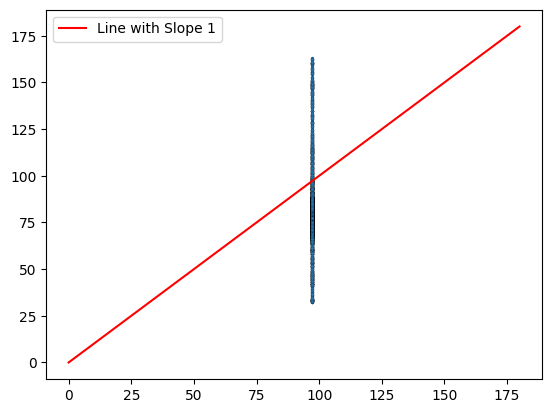

Correlation coefficient:0.0159
RMSE of Right Elbow Angle:26.5869 
Max error :65.9090  epoch_time :190.62


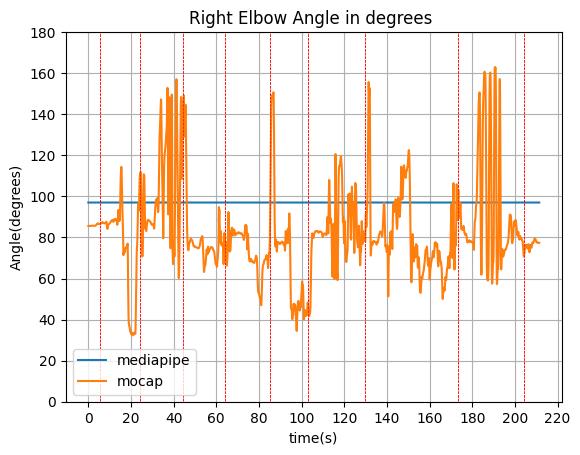

Correlation coefficient: -0.22766832277554946
Correlation coefficient:-0.2277
RMSE of Left Elbow Angle:41.5500 
Max error :164.8839  at epoch_time :199.99


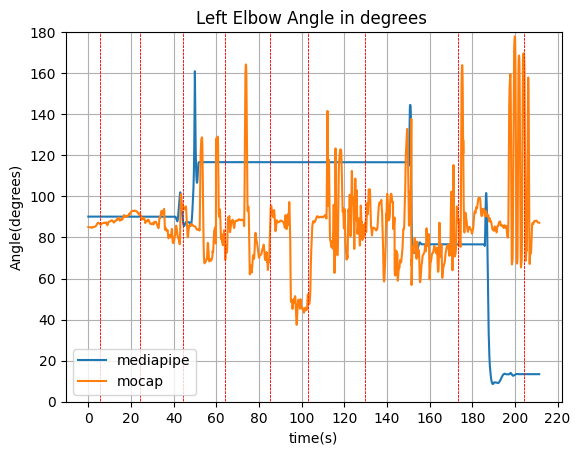

<Figure size 640x480 with 0 Axes>

In [80]:
# graph right elbow angle 

interval=10

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRightElbowAngle, mocapRightElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#plotting scatter
plt.scatter(mpipeRightElbowAngle[0:-1:interval], mocapRightElbowAngle[0:-1:interval], s=5,marker='o',edgecolors='black',linewidth=0.1)
# Plot the line
plt.plot(np.linspace(0, 180, 100), np.linspace(0, 180, 100), label='Line with Slope 1', color='red')
plt.legend()
plt.show()

pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRightElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap')
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapRightElbowAngle,mpipeRightElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Right Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\Right Elbow Angle.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLeftElbowAngle, mocapLeftElbowAngle)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap')
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapLeftElbowAngle,mpipeLeftElbowAngle)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of Left Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\Left Elbow Angle.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

In [81]:
print(mocapRightElbowAngle)
arr = df_mocap['RW_x'].to_numpy()
print(len(np.argwhere(np.isnan(arr))))
print(len(arr))

[85.57047928319612, 85.57396655842749, 85.57725705756171, 85.58035457135931, 85.58326288127834, 85.58598575975235, 85.58852697046513, 85.59089026862272, 85.593079401222, 85.59509810731625, 85.59695011827701, 85.59863915805292, 85.60016894342462, 85.60154318425634, 85.6027655837436, 85.60383983865722, 85.60476963958358, 85.6055586711608, 85.60621061231113, 85.6067291364693, 85.60711791180668, 85.6073806014516, 85.60752086370518, 85.60754235225332, 85.60744871637417, 85.60724360114159, 85.60686851408121, 85.60623196980018, 85.60563665430011, 85.60494810690703, 85.60409585481774, 85.6030515362498, 85.60174042989425, 85.6002864574017, 85.59947449753153, 85.59775668305973, 85.59659132921564, 85.59540874977716, 85.59434507157897, 85.59304138236591, 85.5922590726137, 85.59113474110987, 85.59033244528125, 85.58958002893479, 85.58905288849901, 85.58817547598765, 85.58752006140456, 85.58681828588571, 85.58582486074215, 85.58493577765545, 85.58400288539733, 85.58318837871865, 85.5820260583009, 85

In [82]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        print('error in shoulder_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)
        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])

        try:
            v1,v2=basis[0],basis[1]

        except:
            print('error in tr_frame')
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        print('error in tr_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (abs(w) > 1.0e-13).any():
            basis.append(w/np.linalg.norm(w))
        else:   
            print('zero vector detected')
        if np.linalg.norm(w/np.linalg.norm(w)) > 1.001 or np.linalg.norm(w/np.linalg.norm(w)) < 0.999:
            print(np.linalg.norm(w/np.linalg.norm(w))) 
        
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        print('error in roation matrix calculation')
        print(frame1,frame2)
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [83]:
# callibrating shoulders and trunk

# setting the calibration to 2 seconds in the video
mpipe_cf = 200
mocap_cf = 200
RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [84]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

angle_list = [mpipeRSFE,mpipeRSAA,mpipeRSIE,
              mpipeLSFE,mpipeLSAA,mpipeLSIE,
              mpipeTRFB,mpipeTRLR,mpipeTRRO]

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe


    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(RSC_mpipe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(LSC_mpipe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    if abs(RSeuler[0]) > 80:
        if RSeuler[0] > 0 and abs(RSeuler[1]) > 20:
            mpipeRSFE.append(RSeuler[0]-abs(RSeuler[1]))
        else:
            mpipeRSFE.append(RSeuler[0]+abs(RSeuler[1]))
    else:
        mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    if abs(LSeuler[0]) > 80: 
        if LSeuler[0] > 0 and abs(LSeuler[1]) > 20:
            mpipeLSFE.append(LSeuler[0]-abs(LSeuler[1]))
        else:
            mpipeLSFE.append(LSeuler[0]+abs(LSeuler[1]))
    else:
        mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)
   
    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(RSC_mocap,mocapRSF)
    mocapLS_rotmat=rotation_matrix(LSC_mocap,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    if abs(RSeuler[0]) > 80:
        if RSeuler[0] > 0 and abs(RSeuler[1]) > 20:
            mocapRSFE.append(RSeuler[0]-abs(RSeuler[1]))
        else:
            mocapRSFE.append(RSeuler[0]+abs(RSeuler[1]))
    else:
        mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    if mocapRightElbowAngle[i] < eath:
        mocapRSIE.append(RSeuler[2])
    else:
        mocapRSIE.append(np.nan)

    if abs(LSeuler[0]) > 80:
        if LSeuler[0] > 0 and abs(LSeuler[1]) > 20:
            mocapLSFE.append(LSeuler[0]-abs(LSeuler[1]))
        else:
            mocapLSFE.append(LSeuler[0]+abs(LSeuler[1]))
    else:
        mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    if mocapLeftElbowAngle[i] < eath:
        mocapLSIE.append(LSeuler[2])
    else:
        mocapLSIE.append(np.nan)

    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

mpipeRSFE,mpipeRSAA,mpipeRSIE = savgol_filter(mpipeRSFE,51,3),savgol_filter(mpipeRSAA,51,3),savgol_filter(mpipeRSIE,51,3)
mpipeLSFE,mpipeLSAA,mpipeLSIE = savgol_filter(mpipeLSFE,51,3),savgol_filter(mpipeLSAA,51,3),savgol_filter(mpipeLSIE,51,3)
mpipeTRFB,mpipeTRLR,mpipeTRRO = savgol_filter(mpipeTRFB,51,3),savgol_filter(mpipeTRLR,51,3),savgol_filter(mpipeTRRO,51,3)

mocapRSFE,mocapRSAA,mocapRSIE = savgol_filter(mocapRSFE,51,3),savgol_filter(mocapRSAA,51,3),savgol_filter(mocapRSIE,51,3)
mocapLSFE,mocapLSAA,mocapLSIE = savgol_filter(mocapLSFE,51,3),savgol_filter(mocapLSAA,51,3),savgol_filter(mocapLSIE,51,3)
mocapTRFB,mocapTRLR,mocapTRRO = savgol_filter(mocapTRFB,51,3),savgol_filter(mocapTRLR,51,3),savgol_filter(mocapTRRO,51,3) 

Correlation coefficient: -0.2745062193379597
Correlation coefficient:-0.2745
RMSE of trunk forward/backward: 15.3360 
Max error :46.1732  epoch_time :115.14


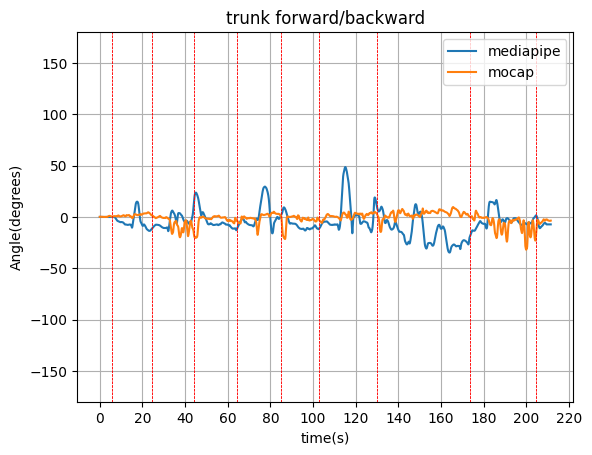

Correlation coefficient: -0.4534218540906974
Correlation coefficient:-0.4534
RMSE of trunk left/right: 7.3324 
Max error :34.5114  epoch_time :200.32


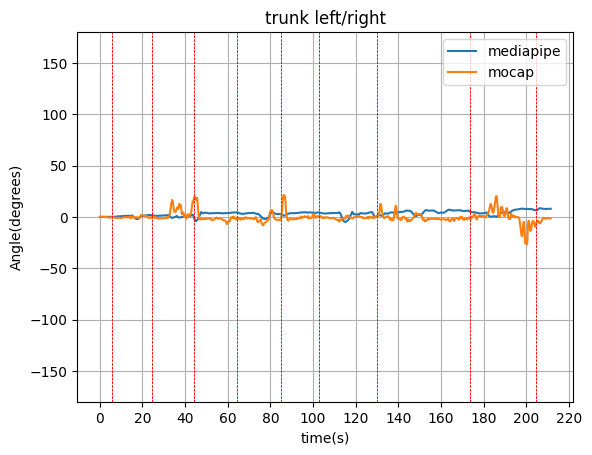

Correlation coefficient: 0.09471901546230432
Correlation coefficient:0.0947
RMSE of trunk rotation: 15.4648 
Max error :52.0076  epoch_time :86.36


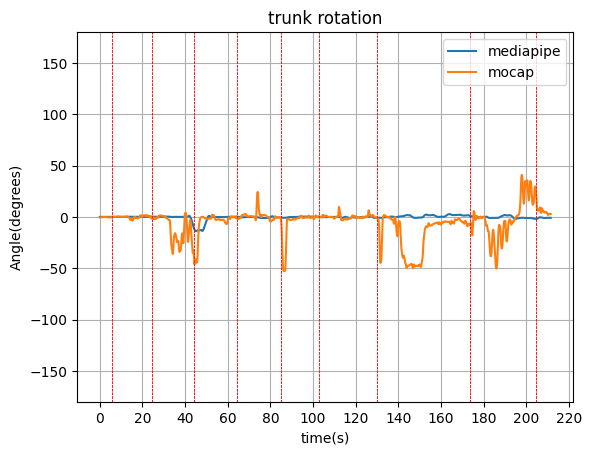

<Figure size 640x480 with 0 Axes>

In [85]:
# Trunk angles
# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRFB, mocapTRFB)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRFB,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk forward/backward')
rmse,me,me_i=errors(mocapTRFB,mpipeTRFB)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk forward/backward: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk forward backward.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRLR, mocapTRLR)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRLR,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRLR,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk left/right')
rmse,me,me_i=errors(mocapTRLR,mpipeTRLR)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk left/right: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk left right.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeTRRO, mocapTRRO)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeTRRO,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapTRRO,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('trunk rotation')
rmse,me,me_i=errors(mocapTRRO,mpipeTRRO)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of trunk rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\trunk rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

Correlation coefficient: 0.06915133569740278
Correlation coefficient:0.0692
RMSE of right shoulder flexion/extension: 21.6244 
Max error :72.1158  epoch_time :80.46


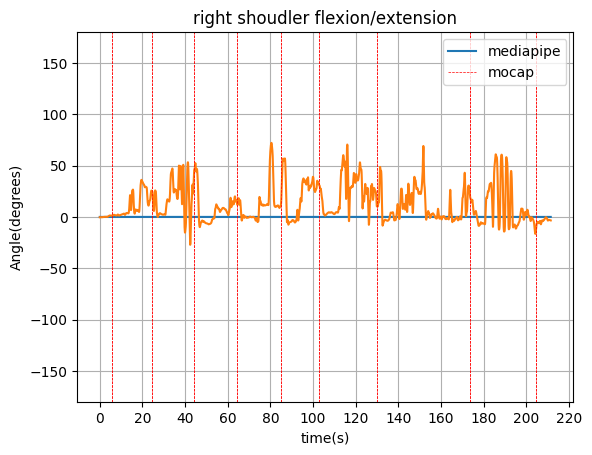

Correlation coefficient: -0.013544177529482422
Correlation coefficient:-0.0135
RMSE of right shoulder abduction/adduction: 12.3341 
Max error :49.2591  epoch_time :149.26


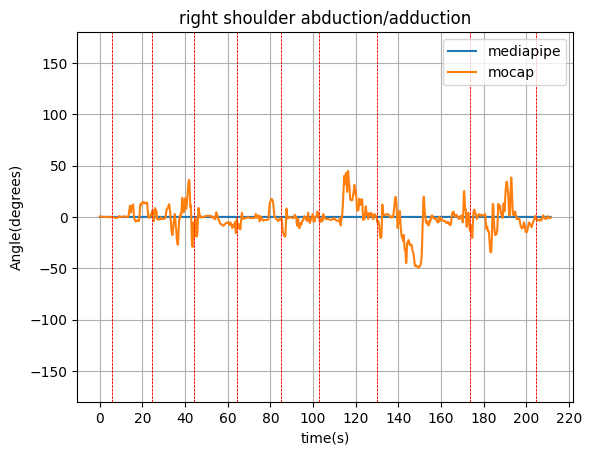

Correlation coefficient: -0.1256939890647338
Correlation coefficient:-0.1257
RMSE of right shoulder internal/external rotation: 33.1354 
Max error :127.8206  epoch_time :183.40


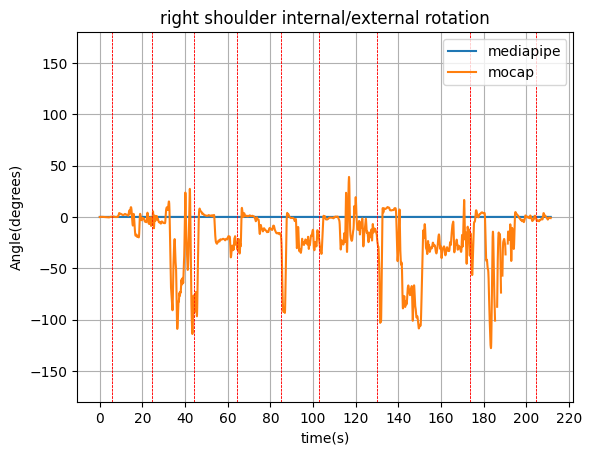

Correlation coefficient: -0.06342351505431224
Correlation coefficient:-0.0634
RMSE of left shoulder flexion/extension: 26.4388 
Max error :95.8458  epoch_time :197.85


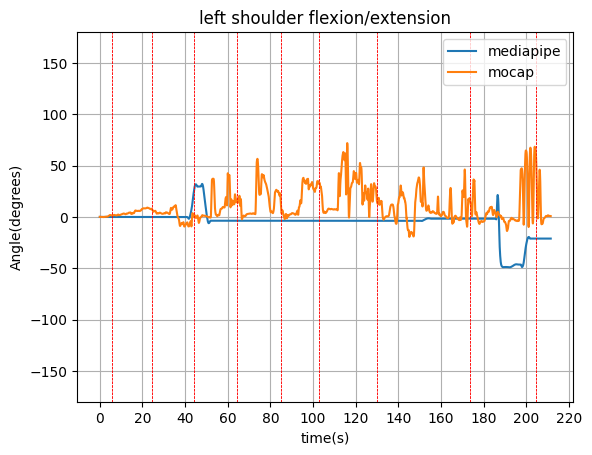

Correlation coefficient: 0.1310095686873486
Correlation coefficient:0.1310
RMSE of left shoulder abduction/adduction: 14.1046 
Max error :69.0388  epoch_time :175.34


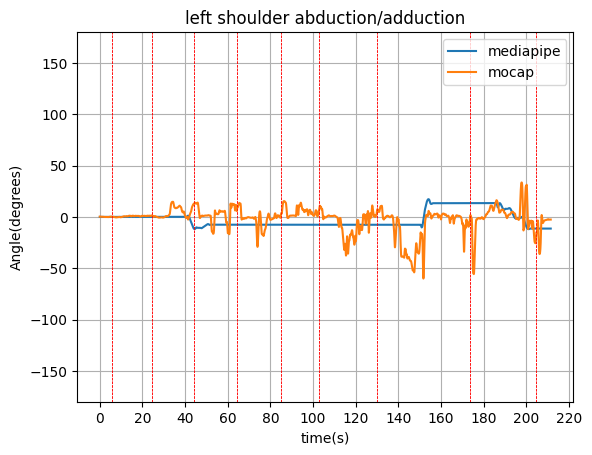

Correlation coefficient: -0.1256939890647338
Correlation coefficient:-0.1257
RMSE of left shoulder internal/external rotation: 42.2775 
Max error :158.4930  epoch_time :149.49


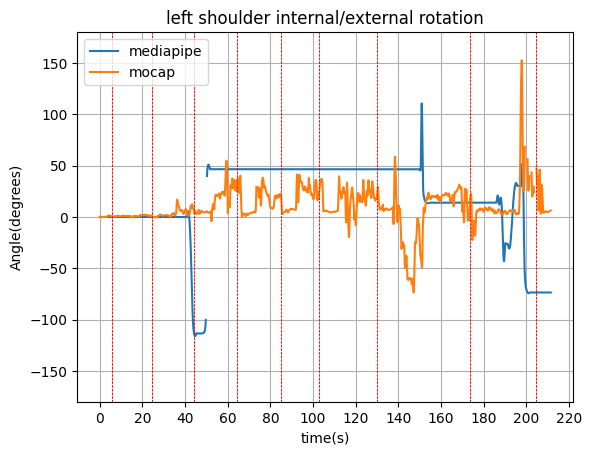

<Figure size 640x480 with 0 Axes>

In [86]:
# Plotting the shoulder angles

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSFE, mocapRSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSFE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')

rmse,me,me_i=errors(mocapRSFE,mpipeRSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoudler flexion extension.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSAA, mocapRSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSAA,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('right shoulder abduction/adduction')

rmse,me,me_i=errors(mocapRSAA,mpipeRSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoulder abduction adduction.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeRSIE1, mocapRSIE1 = np.array(mpipeRSIE), np.array(mocapRSIE)
mask = ~np.isnan(mpipeRSIE1) & ~np.isnan(mocapRSIE1) 
mpipeRSIE1 = mpipeRSIE1[mask]
mocapRSIE1 = mocapRSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeRSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapRSIE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('right shoulder internal/external rotation')

rmse,me,me_i = errors(mocapRSIE,mpipeRSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of right shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\right shoulder internal external rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()


# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSFE, mocapLSFE)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSFE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder flexion/extension')

rmse, me , me_i =errors(mocapLSFE,mpipeLSFE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder flexion extension.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeLSAA, mocapLSAA)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSAA,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder abduction/adduction')

rmse,me,me_i=errors(mocapLSAA,mpipeLSAA)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder abduction adduction.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()

mpipeLSIE1, mocapLSIE1 = np.array(mpipeLSIE), np.array(mocapLSIE)
mask = ~np.isnan(mpipeLSIE1) & ~np.isnan(mocapLSIE1)
mpipeLSIE1 = mpipeLSIE1[mask]
mocapLSIE1 = mocapLSIE1[mask]

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(mpipeRSIE1, mocapRSIE1)
# Print the correlation coefficient and p-value
print("Correlation coefficient:", correlation)
corr_list.append(correlation)

pvt(mpipeLSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time,'mediapipe')
pvt(mocapLSIE,df_mocap['epoch_time'].to_numpy()-epoch_time,'mocap'    )
plt.title('left shoulder internal/external rotation')

rmse, me , me_i = errors(mocapLSIE,mpipeLSIE)
RMSE_str=f"Correlation coefficient:{correlation:.4f}"+"\n"+'RMSE of left shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]:.2f}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.grid()
plt.savefig(directory_path+'\\left shoulder internal external rotation.png',dpi=500)
plt.show()

# Clear the figure for the next graph
plt.clf()


In [87]:
# Showing data in a pptx
graph_dic={'Right Elbow Angle':[mocapRightElbowAngle,mpipeRightElbowAngle],'Left Elbow Angle':[mocapLeftElbowAngle,mpipeLeftElbowAngle],
           'Trunk forward/backward':[mocapTRFB,mpipeTRFB],'Trunk left/right':[mocapTRLR,mpipeTRLR], 'Trunk rotation':[mocapTRRO,mpipeTRRO],
           'Right shoulder flexion/extension':[mocapRSFE,mpipeRSFE],'Right shoulder abduction/adduction':[mocapRSAA,mpipeRSAA],'Right shoulder rotation':[mocapRSIE,mpipeRSIE],
            'Left shoulder flexion/extension':[mocapLSFE,mpipeLSFE],'Left shoulder abduction/adduction':[mocapLSAA,mpipeLSAA] ,'Left shoulder rotation':[mocapLSIE,mpipeLSIE]}
graph_names=list(graph_dic.keys())

# delete the previous graphs pptx if it exists
try:
    os.remove(pth+'\\graphs_'+id+'.pptx')
except:
    pass
# Save the graphs to the PowerPoint presentation
tot=0
error_list=[]
graph_no=0
for graph,error,name in zip(graphs,RMSEs,graph_names):
    save_graph_to_pptx(prs, graph, error)
    err=float(error.split(':')[2].split('\n')[0].strip())
    tot=tot+err
    error_list.append(err)
    
    if task_present:
        table_data=[]
        table_data.append(['task no:','RMSE','Max Error','correlation'])
        mocapList,mpipeList = split_list_by_indexes(graph_dic[name][0],task_index) , split_list_by_indexes(graph_dic[name][1],task_index)
        for i in range(task_no):
            if i == 0:
                continue
            mocapArray ,mpipeArray  = np.array(mocapList[i]) ,np.array(mpipeList[i])
            mask = ~np.isnan(mocapArray) & ~np.isnan(mpipeArray) 
            mocapArray = mocapArray[mask]
            mpipeArray = mpipeArray[mask]
            rmse,me,me_i=errors(mocapArray,mpipeArray)
            slope_mask = high_slope_index(mocapArray,window_length=50,slope_threshold=0.05)
            mocapArray = mocapArray[slope_mask]
            mpipeArray = mpipeArray[slope_mask]
            if len(mocapArray)>50:
                corr=pearsonr(mocapArray,mpipeArray)[0]
            else:
                print(name,i)
                corr=np.nan
            table_data.append([f"task{i}",f"{rmse:.4f}",f"{me:.4f}",f"{corr:.4f}"])
        prs=add_table_slide(prs,name,table_data)
        
    graph_no+=1
        

if True: # average cross all tasks
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[6]
    slide = prs.slides.add_slide(slide_layout)

    left = Inches(0.5)
    top = Inches(1)
    width = Inches(6)
    height = Inches(4.5)

    # Define the number of rows and columns for the table
    num_rows = 12
    num_cols = 3

    # Define the width and height of the table
    table_width = Inches(9.5)  # Adjust the value according to your desired width
    table_height = Inches(3.5)  # Adjust the value according to your desired height

    # Calculate the width and height of each cell in the table
    cell_width = int(table_width / num_cols)
    cell_height = int(table_height / num_rows)

    # Add the table to the slide
    left = top = Inches(0.25)  # Adjust the values to position the table on the slide
    table = slide.shapes.add_table(num_rows, num_cols, left, top, table_width, table_height).table

    # Set the column widths
    for i in range(num_cols):
        table.columns[i].width = cell_width

    # Set the row heights
    for i in range(num_rows):
        table.rows[i].height = cell_height

    # Populate the table with content
    table.cell(0, 0).text = "Angle"
    table.cell(0, 1).text = "RMSE"
    table.cell(0, 2).text = "Correlation"

    for i in range(1,12):
        table.cell(i,0).text = graph_names[i-1]
        table.cell(i,1).text = str(error_list[i-1])
        table.cell(i,2).text = str(f"{corr_list[i-1]:.4f}")

    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(1.5), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = 'Average RMSE: '+str(f'{tot/len(graphs):.4f} \n'+ f'Average Correlation Coefficient: {(np.mean(np.array(corr_list))):.4f}')

if task_present:  # average for each task
    table_data=[]
    table_data.append(['task no:','RMSE','Max Error','correlation'])
    for i in range(task_no):
        rmse_list,me_list,c_list=[],[],[]
        if i == 0:
            continue
        for name in graph_names:
            mocapList,mpipeList = split_list_by_indexes(graph_dic[name][0],task_index) , split_list_by_indexes(graph_dic[name][1],task_index)
            mocapArray ,mpipeArray  = np.array(mocapList[i]) ,np.array(mpipeList[i])
            mask = ~np.isnan(mocapArray) & ~np.isnan(mpipeArray) 
            mocapArray = mocapArray[mask]
            mpipeArray = mpipeArray[mask]
            rmse,me,me_i=errors(mocapArray,mpipeArray)
            slope_mask = high_slope_index(mocapArray,window_length=50,slope_threshold=0.05)
            mocapArray = mocapArray[slope_mask]
            mpipeArray = mpipeArray[slope_mask]
            if len(mocapArray)>50:
                corr=pearsonr(mocapArray,mpipeArray)[0]

            rmse_list.append(rmse)
            me_list.append(me)
            c_list.append(corr)
        table_data.append([f"task{i}",f"{np.mean(np.array(rmse_list)):.4f}",f"{np.mean(np.array(me_list)):.4f}",f"{np.mean(np.array(c_list)):.4f}"])
    prs=add_table_slide(prs,"Task average across all angles",table_data)

print('Average RMSE: '+str(tot/len(graphs)))

id = pth.split('\\')[-1].split('_')[-1]

# Save the presentation
prs.save(pth+'\\graphs_'+id+'.pptx')

Left Elbow Angle 1
Trunk forward/backward 1
Trunk left/right 1
Trunk left/right 6
Trunk rotation 1
Left shoulder flexion/extension 1
Left shoulder abduction/adduction 1
Left shoulder rotation 1
Average RMSE: 23.289536363636362


In [88]:
s=[]
for i in df_mpipe.columns.tolist()[1:-2]:
    if '' in i:
        # Calculate the correlation coefficient and p-value
        correlation, p_value = pearsonr(df_mocap[i],df_mpipe[i])
        # Print the correlation coefficient and p-value
        print(i," Correlation coefficient:", correlation)
        s.append(correlation)
s=np.array(s)
print('mean',s.mean())

LS_x  Correlation coefficient: -0.2753907030300171
LS_y  Correlation coefficient: 0.17118860304024708
LS_z  Correlation coefficient: -0.0876618224952971
LE_x  Correlation coefficient: -0.39242742155401644
LE_y  Correlation coefficient: -0.05907537690609582
LE_z  Correlation coefficient: -0.31261909514171404
LW_x  Correlation coefficient: 0.08977847919516299
LW_y  Correlation coefficient: -0.11385248215419655
LW_z  Correlation coefficient: 0.2308229620833377
RS_x  Correlation coefficient: -0.08091461871050414
RS_y  Correlation coefficient: -0.12750515919463679
RS_z  Correlation coefficient: -0.008341205996338245
RE_x  Correlation coefficient: -0.06751256672333135
RE_y  Correlation coefficient: 0.1365641177981391
RE_z  Correlation coefficient: 0.11538364362974154
RW_x  Correlation coefficient: -0.10273855201426925
RW_y  Correlation coefficient: 0.15017372783683117
RW_z  Correlation coefficient: 0.06452200243855988
TR_x  Correlation coefficient: 0.7381221091647434
TR_y  Correlation coeffi

In [89]:
df=pd.DataFrame()
df['epoch_time']=df_mocap['epoch_time']
df['moRtEl']=pd.Series(mocapRightElbowAngle)
df['moLtEl']=pd.Series(mocapLeftElbowAngle)
df['moTrFB']=pd.Series(mocapTRFB)
df['moTrLR']=pd.Series(mocapTRLR)
df['moTrRO']=pd.Series(mocapTRRO)
df['moRSFE']=pd.Series(mocapRSFE)
df['moRSAA']=pd.Series(mocapRSAA)
df['moRSIE']=pd.Series(mocapRSIE)
df['moLSFE']=pd.Series(mocapLSFE)
df['moLSAA']=pd.Series(mocapLSAA)
df['moLSIE']=pd.Series(mocapLSIE)

df['mpRtEl']=pd.Series(mpipeRightElbowAngle)
df['mpLtEl']=pd.Series(mpipeLeftElbowAngle)
df['mpTrFB']=pd.Series(mpipeTRFB)
df['mpTrLR']=pd.Series(mpipeTRLR)
df['mpTrRO']=pd.Series(mpipeTRRO)
df['mpRSFE']=pd.Series(mpipeRSFE)
df['mpRSAA']=pd.Series(mpipeRSAA)
df['mpRSIE']=pd.Series(mpipeRSIE)
df['mpLSFE']=pd.Series(mpipeLSFE)
df['mpLSAA']=pd.Series(mpipeLSAA)
df['mpLSIE']=pd.Series(mpipeLSIE)

df.to_csv(pth+'\\angles.csv',index=False)

In [90]:
l1=[2,12,3,1,5,2,4,5,2,4,6,1,5,2,4,6,4,5,2,4,5,5]

l2=[l1]

for i in l2:
    i=[2]
print(l1)

[2, 12, 3, 1, 5, 2, 4, 5, 2, 4, 6, 1, 5, 2, 4, 6, 4, 5, 2, 4, 5, 5]
